In [1]:
using PyPlot, HiQGA, Random
cd(@__DIR__)

# Geometry

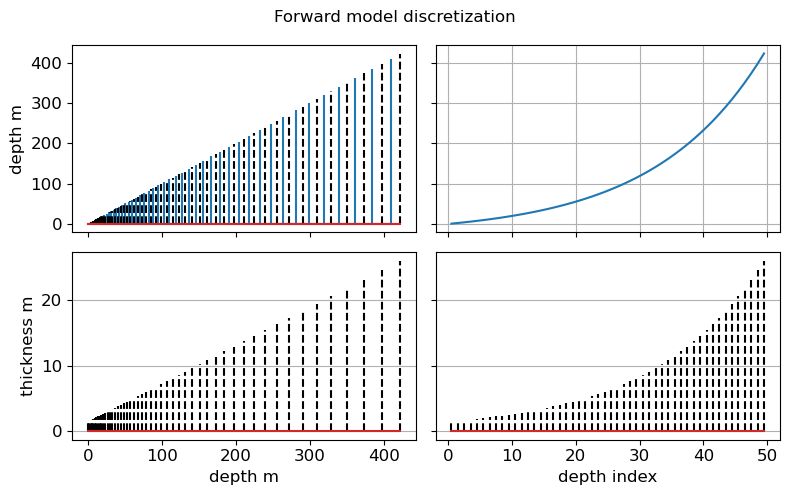

13.0

In [2]:
# model fixed parts, i.e., air
Random.seed!(23)
zfixed   = [-1e5]
ρfixed   = [1e12]
# Model discretization
# Note that the receiver and transmitter need to be in layer 1
zstart = 0.0
extendfrac, dz = 1.06, 1.5
zall, znall, zboundaries = transD_GP.setupz(zstart, extendfrac, dz=dz, n=50, showplot=true)
z, ρ, nfixed = transD_GP.makezρ(zboundaries; zfixed=zfixed, ρfixed=ρfixed);
rRx = 13.

# AEM modeling parameters

In [3]:
# Rx-Tx geometry
zRx = -42.0
zTx = -40.0
include("/scratch/ns59/HiQGA.jl/ASEG_Hobart_Workshop_2024/UDF_data/electronics_halt.jl")
calcjacobian = false # switch off for McMC!
# make SkyTEM operator
aem = transD_GP.SkyTEM1DInversion.dBzdt(;
    timeslow = LM_times, ramplow = LM_ramp, zRxlow=zRx, zTxlow = zTx,
    timeshigh = HM_times, ramphigh = HM_ramp, zRxhigh=zRx, zTxhigh = zTx,
    rRx, rTx, z, ρ, lowpassfcs, calcjacobian);
# Create resistivity model in ohm-m
ρ[(z.>=zstart) .& (z.<50)] .= 20.
ρ[(z.>=50)      .&(z.<80)] .= 1
ρ[(z.>=80)     .&(z.<120)] .= 20
ρ[(z.>=120)    .&(z.<150)] .= 1
ρ[(z.>=150)    .&(z.<250)] .= 50
ρ[(z.>=250)]               .= 150
# add jitter to model in log10 domain
Random.seed!(10)
ρ = 10 .^(0.1*randn(length(ρ)) + log10.(ρ))

51-element Vector{Float64}:
   1.341382983388124e12
  16.544814839634515
  24.779239838115988
  22.61112020246438
  20.506722803537237
  19.044206215637765
  14.62537380424338
  21.47632642722453
  16.843154384000908
  28.355789598476985
  25.729496345687632
  20.87314738232464
  18.73101561106958
   ⋮
  47.67052574218713
  33.487552070558436
  62.52470069992703
  50.363848510776315
 130.48868503812895
 145.05840698011212
 221.1572651991711
 189.85375167595978
 134.87856271911934
 198.70421815564177
 122.48023808196429
 121.54481459591398

# Plot model and data

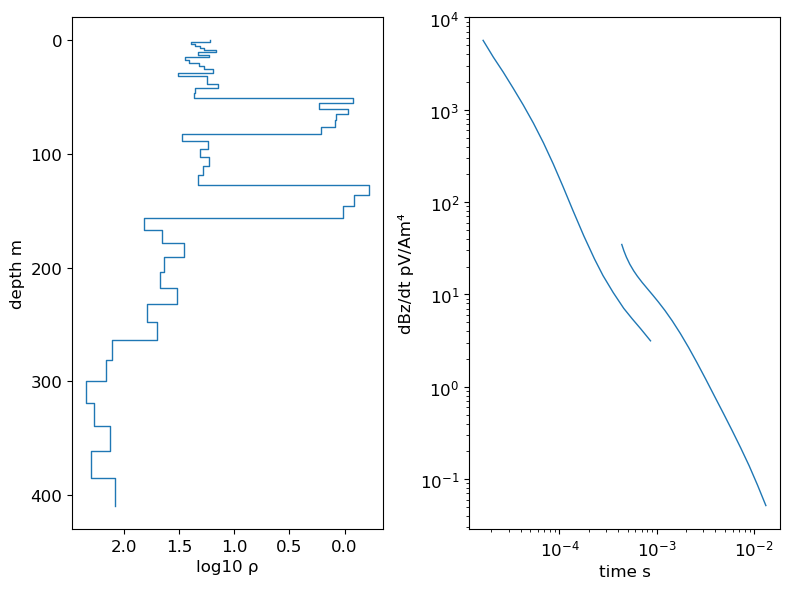

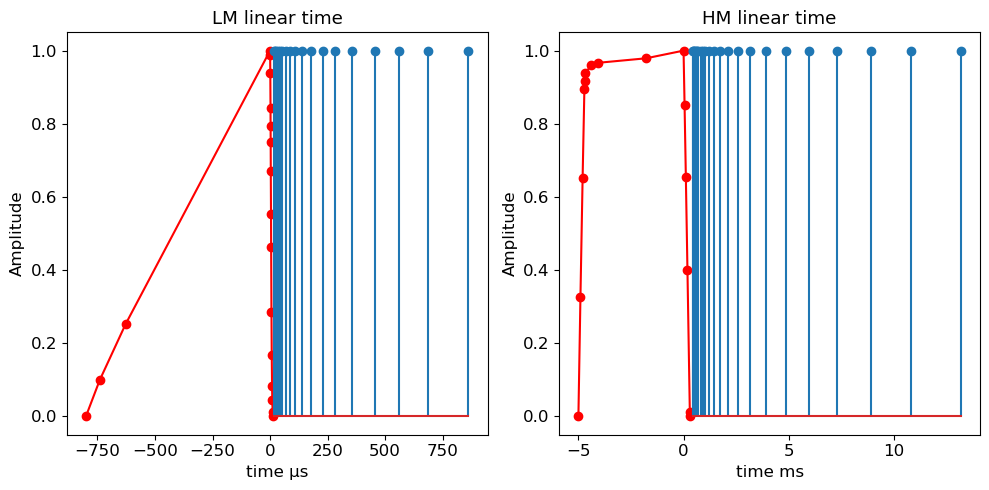

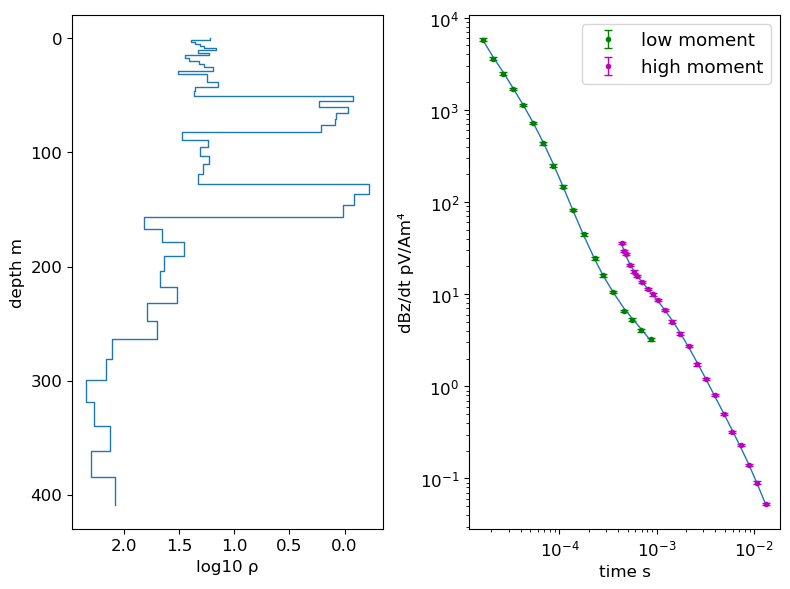

In [4]:
# plot noise free data due to model
transD_GP.plotmodelfield!(aem, log10.(ρ[2:end]))
# add noise to data
transD_GP.SkyTEM1DInversion.makenoisydata!(aem, log10.(ρ[2:end]);
    σ_halt_low=LM_noise, σ_halt_high=HM_noise,
    units = 1e-12)

# Change only if restarting

In [5]:
restart = false
fileprefix = "SkyTEM_synth_"
if !restart # delete earlier runs if starting afresh
    history_mode = "w"
    deletefiles = ["misfits_", "points_", "models_"].*fileprefix.*"s.bin"
    [isfile(f) && rm(f) for f in deletefiles]
else
    history_mode = "a"
end

3-element Vector{Nothing}:
 nothing
 nothing
 nothing

# Prior settings

In [6]:
# type of Gaussian Process kernel
K = transD_GP.GP.OrstUhn()
# number of GP nuclei
nmin, nmax = 2, 40
# log10 RESISTIVITY bounds to sample between
fbounds = [-1 3.]
# depth locations in number of layers to interpolate resistivity to
xall = copy(permutedims(znall))
# bounds of the depth locations
xbounds = permutedims([extrema(znall)...])
# correlation length in layer number units, tolerance nugget for GP resistivity
λ, δ = [2], 0.1

([2], 0.1)

# McMC Proposal specifications as fractions of prior bounds

In [7]:
sdev_pos = 0.05*vec(diff([extrema(znall)...]))
sdev_prop = [0.07*diff(fbounds, dims=2)...]
sdev_dc = [0.01*diff(fbounds, dims=2)...]

1-element Vector{Float64}:
 0.04

# Initialize a stationary GP using these options

In [8]:
opt = transD_GP.OptionsStat(;
            dispstatstoscreen = true, # show/don't stats in Jupyter
            nmin, nmax, xbounds, fbounds, fdataname = fileprefix,
            xall, λ, δ, sdev_prop, sdev_pos, sdev_dc, history_mode,
            quasimultid = false, save_freq = 50, K);
# Specify parallel tempering on multiple workers
nsamples, nchains, nchainsatone = 2001, 5, 1
Tmax = 2.50 # maximum annealing temperature
#

2.5

# Add parallel workers

In [9]:
using Distributed
nprocs() > 1 && rmprocs(workers()) # remove workers from earlier run
addprocs(nchains)
@info "workers are $(workers())"
@everywhere using Distributed
@everywhere using HiQGA.transD_GP

[ Info: workers are [2, 3, 4, 5, 6]


# Run McMC with options on multiple workers

In [10]:
@time transD_GP.main(opt, aem, Tmax=Tmax, nsamples=nsamples, nchains=nchains, nchainsatone=nchainsatone)
rmprocs(workers())

      From worker 2:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth   NaN Death   NaN Position 100.00 Property   NaN DC   NaN")
      From worker 4:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth   NaN Death  0.00 Position   NaN Property   NaN DC   NaN")
      From worker 6:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth  0.00 Death   NaN Position   NaN Property   NaN DC   NaN")
      From worker 5:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth   NaN Death   NaN Position   NaN Property   NaN DC 100.00")
      From worker 3:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth   NaN Death  0.00 Position   NaN Property   NaN DC   NaN")
      From worker 5:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth 27.78 Death 10.34 Position 60.00 Property 47.06 DC 61.90")
      From worker 3:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth 52.63 Death 20.00 Position 31.58 Property 47.62 DC 71.43")
      From worker 4:	[ Info: (HiQGA.transD_GP.OptionsStat, "ARs Birth 23.53 Death 15.79 Positio

Task (done) @0x00001525cb3b5c30

# Plot the sampled misfit

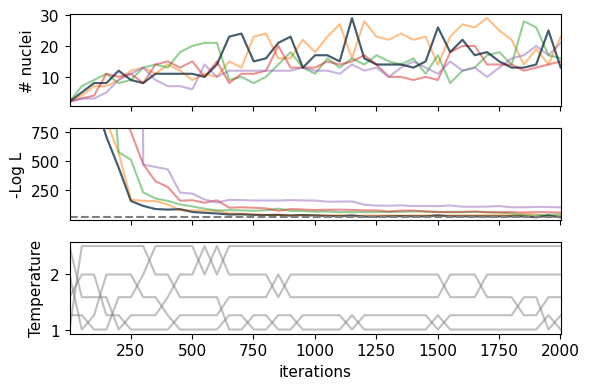

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1525cfdeb830>

In [11]:
transD_GP.getchi2forall(opt)
ax = gcf().axes;
χ² = aem.ndatalow + aem.ndatahigh
ax[2].plot(xlim(), [χ²/2 , χ²/2], "--", color="gray")

# Plot the posterior resistivities

[ Info: Number of chains is 5
[ Info: McMC has run for 2001 iterations
[ Info: obtained models 951 to 2001 at T=1.0


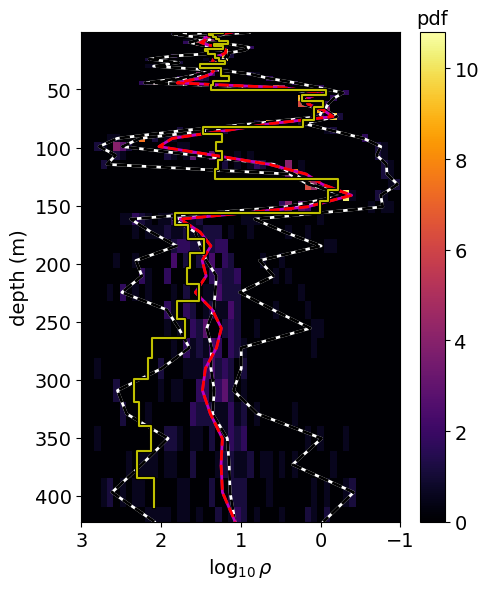

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1525c9385280>

In [12]:
opt.xall[:] .= zall
transD_GP.plot_posterior(aem, opt, burninfrac=0.5, figsize=(5,6),
    qp1=0.05, qp2=0.95, nbins=50, vmaxpc=1.0)
ax = gcf().axes
ax[1].invert_xaxis()
ax[1].step(log10.(ρ[2:end]), z[2:end], color="k", linewidth=3)
ax[1].step(log10.(ρ[2:end]), z[2:end], color="y", linewidth=1.5)

# Plot a few forwards from the posterior

[ Info: Number of chains is 5
[ Info: McMC has run for 2001 iterations
[ Info: obtained models 951 to 2001 at T=1.0


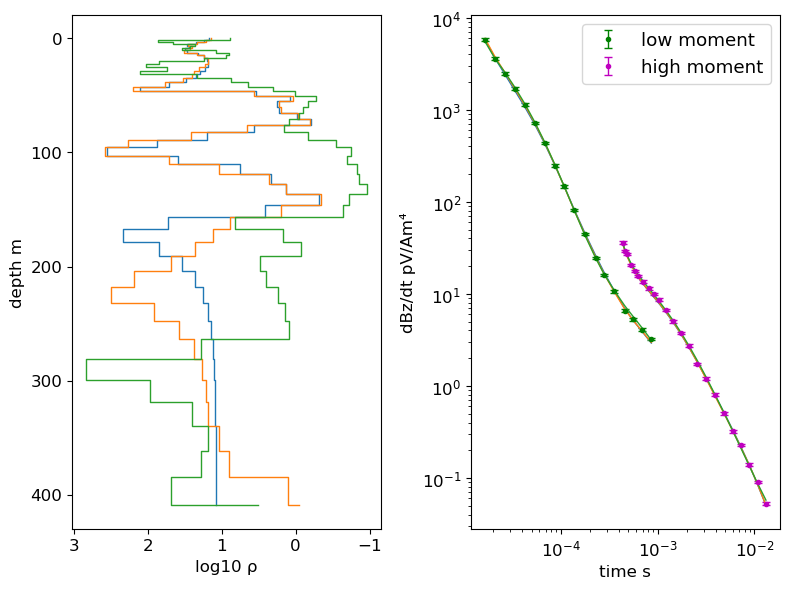

In [13]:
mprob = transD_GP.CommonToAll.assembleTat1(opt, :fstar, temperaturenum=1)
transD_GP.plotmodelfield!(aem, mprob[1:10:end]);

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*